# Create CIGALE input files
-----------------------------------------------

Here we create the photometry files that we use as an input to [CIGALE](https://cigale.lam.fr/).  

The code for creating the phot files was develoved by [Andrés Ramos](a.f.ramos.padilla@rug.nl ).

In [1]:
import numpy as np
import astropy.units as u

from astropy.table import Table, Column
from pathlib import Path
from matplotlib import pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:18px !important; }</style>"))

In [2]:
path_raw='../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
Path(path_CIGALE_phot).mkdir(parents=True, exist_ok=True)
path_FINAL = '../Datos/Final/'
Path(path_FINAL).mkdir(parents=True, exist_ok=True)

date_sample = 'Sep_02_2022'
NeIR_obj_t = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')
print('Seyfert galaxies with Ne lines info:',len(NeIR_obj_t))
#NeIR_obj_t.show_in_notebook()

Seyfert galaxies with Ne lines info: 303


## Create equivalences between NED and CDS tables
Here we create a list for the different names of the bands in NED and CDS. Each row represents the same band.

In [3]:
Equival = [['2-10 keV (XMM)', None, None],
           ['0.5-2 keV (XMM)', None, None],
           ['GALEX:FUV', 'FUV (GALEX)', None],
           ['GALEX:NUV', 'NUV (GALEX)', None],
           ["SDSS:u'", 'SDSS:u', 'u (SDSS) AB'],
           ["SDSS:g'", 'SDSS:g', 'g (SDSS) AB'],
           ["SDSS:r'", 'SDSS:r', 'r (SDSS) AB'],
           ["SDSS:i'", 'SDSS:i', 'i (SDSS) AB'],
           ["SDSS:z'", 'SDSS:z', 'z (SDSS) AB'],
           ['2MASS:J', 'J (2MASS) AB', None],
           ['2MASS:H', 'H (2MASS) AB', None],
           ['2MASS:Ks', 'Ks (2MASS) AB', None],
           ['WISE:W1', 'W1 (WISE)', None],
           [':=3.6um', '3.6 microns (IRAC)', None],
           [':=4.5um', '4.5 microns (IRAC)', None],
           ['WISE:W2', 'W2 (WISE)', None],
           [':=5.8um', '5.8 microns (IRAC)', None],
           [':=8um', '8.0 microns (IRAC)', None],
           ['IRAS:12', '12 microns (IRAS)', None],
           ['WISE:W3', 'W3 (WISE)', None],
           ['WISE:W4', 'W4 (WISE)', None],
           ['Spitzer/MIPS:24', '24 microns (MIPS)', None],
           ['IRAS:25', '25 microns (IRAS)', None],
           ['IRAS:60', '60 microns (IRAS)', None],
           ['Herschel/PACS:70', '70 microns (PACS)', None],
           ['Spitzer/MIPS:70', '70 microns (MIPS)', None],
           ['IRAS:100', '100 microns (IRAS)', None],
           ['Herschel/PACS:100', '100 microns (PACS)', None],
           ['Spitzer/MIPS:160', '160 microns (MIPS)', None],
           ['Herschel/PACS:160', '160 microns (PACS)', None],
           ['Herschel/SPIRE:250', '250 microns (SPIRE)', ':=250um'],
           ['Herschel/SPIRE:350', '350 microns (SPIRE)', ':=350um'],
           ['Herschel/SPIRE:500', '500 microns (SPIRE)', ':=500um'],
           [':=5GHz', ':=6cm', '4.89 GHz (VLA)'],
           [':=1.5GHz', ':=20cm', '1.46 GHz (VLA)'],
           [':=1.4GHz', ':=21cm', '1.4GHz']
           ]

## Transforming photometry to CIGALE table

The next class allows us to transform the units of the SEDs in the selected bands.

In [4]:
class TransformCIGALE:
    """Class to plot the SEDs and create a row with the right units"""
    def __init__(self, sed):
        self.sed = sed
        #self.init_plot() # To check the SED
        self.create_row()

    def init_plot(self):
        "Plot the SED"
        plt.errorbar(self.sed['Wave'], self.sed['Flux'], yerr=self.sed['F_er'], fmt='o')
        plt.xlim(1e-6, 1e6)
        plt.loglog()

    def create_row(self):
        """Calculate the flux and error to use for the SED in CIGALE"""
        # Number of filtets/bands and their errors
        self.row = np.full(72, np.nan)
        iband = 0
        for band in Equival:
            crop = self.sed[np.logical_or.reduce([self.sed['Filter'] == band[0],
                                                  self.sed['Filter'] == band[1],
                                                  self.sed['Filter'] == band[2]])]
            flux = np.mean(crop['Flux'])
            std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)
            self.row[iband] = flux*1000  # To send in mJy
            self.row[iband+1] = std*1000  # To send in mJy
            iband += 2

We create a table with all the CIGALE bands/filters and fill it with the information that we get from NED and CDS. In some cases some of the galaxies are not useful because the bands are not found initially. This could take some minutes.

In [5]:
CIGALEFilter = ['xray_box_car_2to10keV', 'xray_box_car_0p5to2keV', 'FUV', 'NUV',
                'u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'J_2mass',
                'H_2mass', 'Ks_2mass', 'WISE1', 'IRAC1', 'IRAC2', 'WISE2', 'IRAC3', 'IRAC4',
                'IRAS1', 'WISE3', 'WISE4', 'MIPS1', 'IRAS2', 'IRAS3', 'PACS_blue', 'MIPS2',
                'IRAS4', 'PACS_green', 'MIPS3', 'PACS_red', 'PSW_ext', 'PMW_ext', 'PLW_ext',
                'VLA_C', 'VLA_L', 'HI21cm']
# VLAC is 6cm ,VLAL is 20 cm and HI21cm is 1.4GHz
CIGFilt = [[filt, filt+'_err'] for filt in CIGALEFilter]
CIG = Table(names=np.array(CIGFilt).ravel())
GoodGalaxies = []

for igal, Galaxy in enumerate(NeIR_obj_t['Main_Id']):
    #     figure()
    try:
        sed_file = Table.read(path_SED+Galaxy + '_Phot.txt',
                          format='ascii')
        if len(sed_file) == 0:
            print(Galaxy, igal, 'No useful phot.')
        else:
            GoodGalaxies.append(igal)
            CIG.add_row(TransformCIGALE(sed_file).row)
    except FileNotFoundError:
        print(Galaxy, igal, 'No Phot. ERROR')

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_267803/2558554763.py:24: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)


In [6]:
CIG.colnames

['xray_box_car_2to10keV',
 'xray_box_car_2to10keV_err',
 'xray_box_car_0p5to2keV',
 'xray_box_car_0p5to2keV_err',
 'FUV',
 'FUV_err',
 'NUV',
 'NUV_err',
 'u_prime',
 'u_prime_err',
 'g_prime',
 'g_prime_err',
 'r_prime',
 'r_prime_err',
 'i_prime',
 'i_prime_err',
 'z_prime',
 'z_prime_err',
 'J_2mass',
 'J_2mass_err',
 'H_2mass',
 'H_2mass_err',
 'Ks_2mass',
 'Ks_2mass_err',
 'WISE1',
 'WISE1_err',
 'IRAC1',
 'IRAC1_err',
 'IRAC2',
 'IRAC2_err',
 'WISE2',
 'WISE2_err',
 'IRAC3',
 'IRAC3_err',
 'IRAC4',
 'IRAC4_err',
 'IRAS1',
 'IRAS1_err',
 'WISE3',
 'WISE3_err',
 'WISE4',
 'WISE4_err',
 'MIPS1',
 'MIPS1_err',
 'IRAS2',
 'IRAS2_err',
 'IRAS3',
 'IRAS3_err',
 'PACS_blue',
 'PACS_blue_err',
 'MIPS2',
 'MIPS2_err',
 'IRAS4',
 'IRAS4_err',
 'PACS_green',
 'PACS_green_err',
 'MIPS3',
 'MIPS3_err',
 'PACS_red',
 'PACS_red_err',
 'PSW_ext',
 'PSW_ext_err',
 'PMW_ext',
 'PMW_ext_err',
 'PLW_ext',
 'PLW_ext_err',
 'VLA_C',
 'VLA_C_err',
 'VLA_L',
 'VLA_L_err',
 'HI21cm',
 'HI21cm_err']

In [7]:
print('Percentage of galaxies with xray_box_car_2to10keV data:',sum(~np.isnan(CIG[CIG.colnames[0]].data))/len(CIG))
print('Percentage of galaxies with xray_box_car_0p5to2keV data:',sum(~np.isnan(CIG[CIG.colnames[3]].data))/len(CIG))

Percentage of galaxies with xray_box_car_2to10keV data: 0.30033003300330036
Percentage of galaxies with xray_box_car_0p5to2keV data: 0.24422442244224424


In [8]:
print('Percentage of galaxies with VLA_C data:',sum(~np.isnan(CIG[CIG.colnames[66]].data))/len(CIG))
print('Percentage of galaxies with VLA_L data:',sum(~np.isnan(CIG[CIG.colnames[68]].data))/len(CIG))
print('Percentage of galaxies with HI21cm data:',sum(~np.isnan(CIG[CIG.colnames[70]].data))/len(CIG))

Percentage of galaxies with VLA_C data: 0.11551155115511551
Percentage of galaxies with VLA_L data: 0.07920792079207921
Percentage of galaxies with HI21cm data: 0.7623762376237624


In [9]:
CIG = CIG[CIG.colnames[4:-6]]  # Remove x-ray and radio wavelengths

We add the identifier (main_id) and the redshift from SIMBAD.

In [10]:
col_name = Column(name='id', data=NeIR_obj_t['Main_Id'][GoodGalaxies])
CIG.add_column(col_name, 0)
col_z = Column(name='redshift', data=NeIR_obj_t['redshift'][GoodGalaxies])
CIG.add_column(col_z, 1)

In [11]:
#CIG.show_in_notebook()

## Clean photometric values

Then, for each filter, we verify if the relative error is higher than 33%, in those cases we do not use that information for the modeling. In addition, we remove information with limits, that in some cases are annotated as negative values.

In [12]:
for igal in range(len(CIG)):
    for icol in CIG.colnames[2::2]:
        if CIG[icol+'_err'][igal]/CIG[icol][igal] >= 1/3.:  # Higher than 33%
            print('Idx:',igal,CIG['id'][igal], icol, CIG[icol+'_err'][igal]/CIG[icol][igal])
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal] = np.nan
        if CIG[icol+'_err'][igal]/CIG[icol][igal] <= 0:  # Negative Limits
            print('Idx:',igal,'Negative', CIG['id'][igal], icol)
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal] = np.nan

Idx: 1 2MASS J13000535+1632148 FUV 0.4492512399613503
Idx: 4 NGC  4945 H_2mass 0.34200465652699563
Idx: 8 LEDA   45656 IRAS3 0.4358974358974359
Idx: 8 LEDA   45656 IRAS4 0.33548387096774196
Idx: 13 LEDA 3095998 H_2mass 0.3611261953891703
Idx: 13 LEDA 3095998 Ks_2mass 0.4049506150848603
Idx: 13 LEDA 3095998 WISE4 0.4394152443038262
Idx: 13 LEDA 3095998 PSW_ext 0.4003778774826832
Idx: 15 NGC  4477 IRAC3 20.779224522371056
Idx: 16 LEDA   89511 FUV 0.3487694417282854
Idx: 18 Mrk  493 IRAS1 0.35659711704621994
Idx: 21 2MASS J22255427+1958370 NUV 0.6543330714654052
Idx: 21 2MASS J22255427+1958370 H_2mass 0.3977961022174125
Idx: 24 [VV2000] J235225.0+244009 J_2mass 0.44079420615248804
Idx: 25 3C 196 H_2mass 0.6532557650937084
Idx: 26 2MASX J10032788+5541535 FUV 0.3700046809357876
Idx: 26 2MASX J10032788+5541535 J_2mass 0.4372501858121231
Idx: 26 2MASX J10032788+5541535 H_2mass 0.5033962330961406
Idx: 26 2MASX J10032788+5541535 Ks_2mass 0.5585180838315121
Idx: 29 IRAS 11215-2806 FUV 0.65966116

We define a minimum error for each filter to avoid overfitting

In [13]:
def add_min_err(phot_tab, list_bands, error):
    """Function to add a minimum error for the bands"""
    for col in list_bands:
        rel_error = phot_tab[col+'_err']/phot_tab[col]
        phot_tab[col+'_err'] = np.fmax(rel_error, error)*phot_tab[col]

In [14]:
add_min_err(CIG, ['FUV', 'NUV'], 0.1)
add_min_err(CIG, ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime'], 0.02)
add_min_err(CIG, ['J_2mass', 'H_2mass', 'Ks_2mass'], 0.02)
add_min_err(CIG, ['IRAC1', 'IRAC2', 'IRAC3', 'IRAC4'], 0.03)
add_min_err(CIG, ['MIPS1', 'MIPS2', 'MIPS3'], 0.04)
add_min_err(CIG, ['WISE1', 'WISE2', 'WISE3', 'WISE4'], 0.06)
add_min_err(CIG, ['PACS_blue', 'PACS_green', 'PACS_red'], 0.1)
add_min_err(CIG, ['PSW_ext', 'PMW_ext', 'PLW_ext'], 0.07)

-------------------
## Remove galaxies without energy balance

Then, we look for galaxies where the energy balance cannot be well constrained (i.e. galaxies where there is not enough bands in the optical and IR wavelengths).

In [15]:
BadGalaxies = []
for igal, Lrow in enumerate(CIG):
    IRPhotPoints = sum(~np.isnan(list(Lrow.as_void())[22:]))/2  # From WISE to PLW
    OpPhotPoints = sum(~np.isnan(list(Lrow.as_void())[2:22]))/2  # From FUV to Ks
    if IRPhotPoints < 3 or OpPhotPoints < 5:
         print('Galaxy %s has %i useful photometry points' %
               (Lrow['id'], IRPhotPoints+OpPhotPoints))
         BadGalaxies.append(igal)

Galaxy NGC  4945 has 15 useful photometry points
Galaxy NAME 3C 330G2 has 6 useful photometry points
Galaxy 2MASS J22255427+1958370 has 8 useful photometry points
Galaxy LEDA   90196 has 12 useful photometry points
Galaxy MCG+04-48-002 has 22 useful photometry points
Galaxy [VV2000] J235225.0+244009 has 10 useful photometry points
Galaxy 3C 196 has 10 useful photometry points
Galaxy NAME Circinus Galaxy has 12 useful photometry points
Galaxy Mrk  463E has 13 useful photometry points
Galaxy NGC  1365 has 22 useful photometry points
Galaxy LEDA   27453 has 12 useful photometry points
Galaxy NAME Cyg A has 11 useful photometry points
Galaxy IRAS 11119+3257 has 14 useful photometry points
Galaxy 2MASS J14533151+1353587 has 13 useful photometry points
Galaxy 2C 1066 has 8 useful photometry points
Galaxy ICRF J054236.1+495107 has 9 useful photometry points
Galaxy 2MASS J10520202+5633010 has 10 useful photometry points
Galaxy 3C 343.1 has 3 useful photometry points
Galaxy ICRF J145907.5+71401

In [16]:
print('The total galaxies to remove are %d'%len(BadGalaxies))

The total galaxies to remove are 51


To complement this information we plot the total photometry points in the `BadGalaxies`.

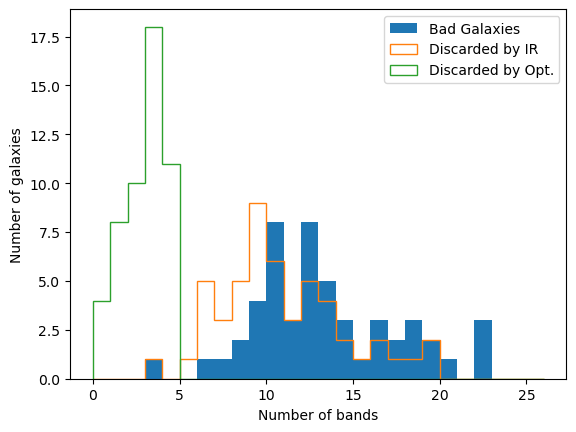

In [17]:
Tpins = []
TpinsIR = []
TpinsOp = []
for Lrow in CIG[BadGalaxies]:
    # All the bad galaxies
    Tpins.append(sum(~np.isnan(list(Lrow.as_void())[2:]))/2)
    # Galaxies discarded due to IR wavelegnths
    TpinsIR.append(sum(~np.isnan(list(Lrow.as_void())[22:]))/2)
    # Galaxies discarded due to Opt. wavelengths
    TpinsOp.append(sum(~np.isnan(list(Lrow.as_void())[2:22]))/2)
plt.hist(Tpins, bins=np.linspace(0, 26, 27), label='Bad Galaxies')
plt.hist(TpinsIR, bins=np.linspace(0, 26, 27),
         histtype='step', label='Discarded by IR')
plt.hist(TpinsOp, bins=np.linspace(0, 26, 27),
         histtype='step', label='Discarded by Opt.')
plt.ylabel('Number of galaxies')
plt.xlabel('Number of bands')
plt.legend()

Most of the `BadGalaxies` are located in a large range of redshifts, mainly affecting galaxies at redshifts above $z=0$. This means that some of these galaxies are not well covered in some of the selected instruments and/or that the photometric values are not well constrained.

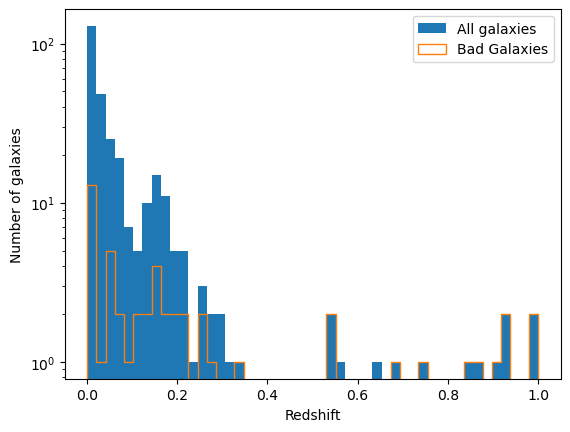

In [18]:
Redbins = np.linspace(0, 1.0, 50)
plt.hist(CIG['redshift'], bins=Redbins, label='All galaxies')
plt.hist(CIG[BadGalaxies]['redshift'], bins=Redbins, histtype='step', label='Bad Galaxies')
plt.xlabel('Redshift')
plt.ylabel('Number of galaxies')
plt.yscale('log')
plt.legend()

We save in a different file those galaxies that do not fulfill the energy balance we want. And then, we removed them from the sample.

In [19]:
CIG[BadGalaxies].write('../Datos/Complementary/CIGPhot_BadEnergyBalance.tbl', format='ascii',overwrite=True)

# Remove galaxies with bad energy balance coverage
CIG.remove_rows(BadGalaxies)

---------------------------
## Separating galaxies depending on redshift for the CIGALE photometry files

With this the sample of galaxies will have a range on redshifts of:

In [20]:
print("Min z=%.2f, Max z=%.2f and Median z~%.2f"%(
    np.min(CIG['redshift']),
    np.max(CIG['redshift']),
    np.median(CIG['redshift'])))

Min z=-0.00, Max z=0.65 and Median z~0.02


We found that most of our sample are below 𝑧=0.40, with a maximum at 𝑧=0.65, so we are going to split the galaxies in ten different groups/files to split the CIGALE runs and avoid computational overwork in CIGALE.

In [21]:
cnt, zbin = np.histogram(CIG['redshift'], bins=np.linspace(-0.01, 1.0, 100))
z_splits = np.percentile(zbin[:-1][cnt > 0], np.linspace(0, 100, 11))
z_splits[-1] += 0.01  # To add the last galaxy
group_zfile = np.digitize(CIG['redshift'], z_splits)

In [22]:
z_splits

array([-0.01      ,  0.02060606,  0.05121212,  0.08181818,  0.11242424,
        0.1430303 ,  0.17363636,  0.20424242,  0.24505051,  0.29606061,
        0.65292929])

Now we save the files for each group and count the number of galaxies per group.

In [23]:
csd = 0
for i in range(1, max(group_zfile)+1):
    csd += len(CIG[group_zfile == i])
    print('Group %i with %d galaxies' % (i, len(CIG[group_zfile == i])))
    CIG[group_zfile == i].write(path_CIGALE_phot+'CIGPhot_EnergyBal_'+str(i)+'.tbl',
                                format='ascii',overwrite=True)
assert len(CIG) == csd

Group 1 with 117 galaxies
Group 2 with 59 galaxies
Group 3 with 25 galaxies
Group 4 with 8 galaxies
Group 5 with 9 galaxies
Group 6 with 17 galaxies
Group 7 with 6 galaxies
Group 8 with 4 galaxies
Group 9 with 3 galaxies
Group 10 with 4 galaxies


We plot the distribution on redshift, with the bins defined for each final group.

Text(0, 0.5, 'Counts')

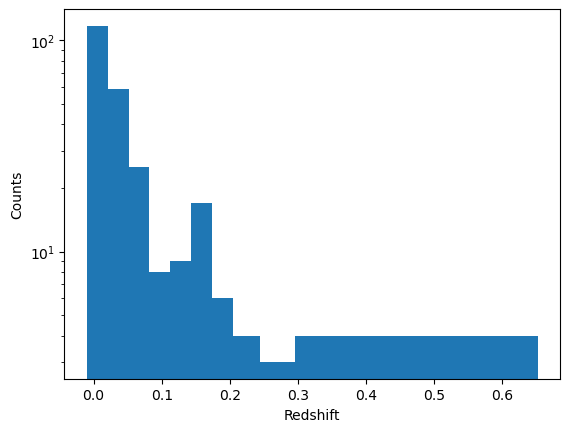

In [24]:
plt.hist(CIG['redshift'], bins=z_splits, log=True)
plt.xlabel('Redshift')
plt.ylabel('Counts')

Finally, we also save a file for all the galaxies, as in some cases this file is useful.

In [25]:
CIG.write(path_FINAL+'CIGPhot_EnergyBal_All.tbl', format='ascii',overwrite=True)

In [26]:
len(CIG)

252

-------------------------------------

## Notebook info:

In [27]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 7.31.1

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

numpy     : 1.21.5
matplotlib: 3.5.2
astropy   : 5.1

Watermark: 2.3.1

